# Speech Augmentation Tutorial

A popular saying in machine learning is "*there is no better data than more data*". However, collecting new data can be expensive and we must cleverly use the available dataset. 

One popular technique is called **speech augmentation**. The idea is to artificially corrupt the original speech signals to give the network the "*illusion*" that we are processing a new signal. This acts as a powerful *regularizer*, that normally helps neural networks improving generalization and thus achieve better performance on test data.

SpeechBrain currently supports the following augmentations:
1. Speed Perturbation
2. Time Dropout (Chunk Drop)
3. Frequency Dropout (Freq Drop)
4. Clipping

Speechbrain supports *Environmental Corruption* (i.e, adding noise and reverberation). This part is covered here[add link].


The augmentation techniques are implemented in `speechbrain.processing.speech_augmentation`. Moreover, in `speechbrain.lobes.augment` we combine these techniques and provide an interface to randomly activate them.

In the following, we will describe all the aforementioned techniques. First of all, let's install SpeechBrain.




In [1]:
%%capture
!pip install speechbrain

Let's also download a speech signal for testing:

In [2]:
%%capture
!wget https://www.dropbox.com/s/u8qyvuyie2op286/spk1_snt1.wav

## 1. Speed Perturbation
With Speed perturbation, we resample the audio signal to a sampling rate that is a bit different from the original one.  With this simple trick we can synthesize a speech signal that sounds a bit "*faster*" or "*slower*" than the original one. Note that not only the speaking rate is affected, but also the speaker characteristics such as pitch and formants.

Let's now try it! 

First, let's read a speech signal

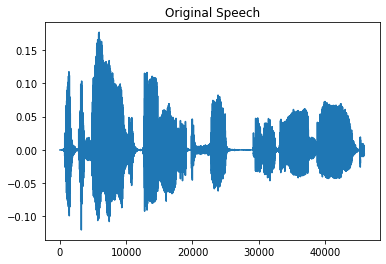

In [3]:
import matplotlib.pyplot as plt
from speechbrain.dataio.dataio import read_audio
signal = read_audio('spk1_snt1.wav')
plt.figure(1)
plt.title("Original Speech")
plt.plot(signal)
plt.show()

You can also play the audio

In [4]:
from IPython.display import Audio
Audio('spk1_snt1.wav')

We can now initalize the speed perturbator:

In [5]:
from speechbrain.processing.speech_augmentation import SpeedPerturb

perturbator = SpeedPerturb(orig_freq=16000, speeds=[90], perturb_prob=1.0)

The speed perturbator is a class that can be initialized with three parameters:


*   **orig_freq**: it is the sampling frequency of the original signal
*   **speeds**: It is a list with all the speeds that the signal should be changed to, as a percentage of the original signal (i.e, `speed=[100]` won't change the original signal). When adding more values (e.g, `speed=[90, 100, 110, 120]`) the speed will be randomly chosen among the specified values.
* **perturb_prob**: It is the chance that the batch will be perturbed.

Let's now apply it to the original signal:

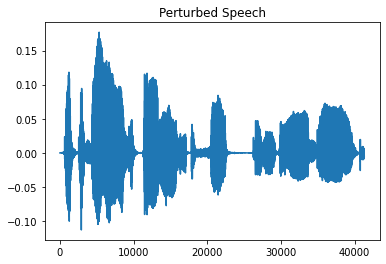

torch.Size([1, 45920])
torch.Size([1, 41328])


In [6]:
clean = signal.unsqueeze(0) # [batch, time]
perturbed = perturbator(clean)

plt.figure(1)
plt.title("Perturbed Speech")
plt.plot(perturbed.squeeze())
plt.show()

print(clean.shape)
print(perturbed.shape)

Audio(perturbed,rate=16000)


The perturbed tensor contains the signal with the perturbed speech. The change factor is 90% as can be observed from the shapes of the original vs perturbed signals (41328/45920 = 0.9)

One more thing to note is that this function supports multiple batches in input and the original signal must be unsqueezed to allocate the batch dimension in the first dimension of the tensor.


## 2. Time Dropout
Drop chunk replaces some random chunks of the original waveform with zeros. The intuition is that the neural network should provide good performance even when some piece of the signal is missing. Conceptually, this similar to **dropout**. The difference is that this is applied to the input waveform only. The other difference is that we drop consecutive samples rather than randomly selected elements like in dropout. 

Let's see an example:

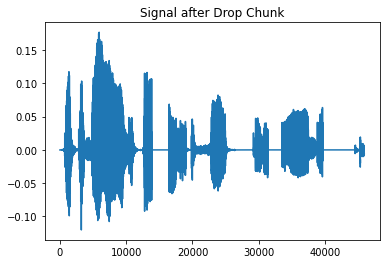

In [7]:
import torch
from speechbrain.processing.speech_augmentation import DropChunk

dropper = DropChunk(drop_length_low=2000, drop_length_high=3000, drop_count_low=5, drop_count_high=10)
length = torch.ones(1)
dropped_signal = dropper(clean, length)

plt.figure(1)
plt.title("Signal after Drop Chunk")
plt.plot(dropped_signal.squeeze())
plt.show()

Audio(dropped_signal,rate=16000)


In the example above, we exaggerated a bit to make the effect more evident. The number of zeros can be managed by playing with the following parameters:

* **drop_length_low** and **drop_length_high** , that determines the maximum and minimum length of the random chunk of zeros.
* **drop_count_low** and **drop_count_high** , that affect the number of random chunks to add into the original signal

The length vector is needed because we can process in parallel batches of signals with different lengths. The length vector contains relative lengths for each sentence composing the batch (e.g, for two batches we can have lenght=[0.8 1.0] where 1.0 is the length of the longest sentence in the batch). In this case, we have a batch composed of a single sentence, and the relative length is thus length=[1.0].

## 3. Frequency Dropout
Drop Freq instead of adding zeros in the time domain, it adds zeros in the **frequency domain**. This can be achieved by filtering the original signal with **band-stop filters** randomly selected. Similarly to drop chunk, the intuition is that the neural network should work well even when some frequency channels are missing.




Text(0, 0.5, 'Frequency')

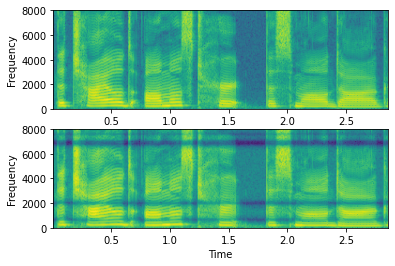

In [8]:
from speechbrain.processing.speech_augmentation import DropFreq

dropper = DropFreq(drop_count_low=5, drop_count_high=8)
dropped_signal = dropper(clean)

# Let's plot the two spectrograms
plt.subplot(211)
plt.specgram(clean.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(dropped_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

The amount of frequency drop is controlled with the following parameters:


*   **drop_count_low**/**drop_count_high**, that impact on the number of frequency bands to drop.
*   **drop_freq_low**/**drop_freq_high**, that correspond to the minimum and maximum frequencies that can be dropped.  
*   **drop_width**, which corresponds to the width of the band to drop.

## 4. Clipping
Another way to remove some piece of information from a speech signal is to add clipping. It a form of non-linear distortions that clamps the max absolute amplitude of the signal (thus adding a saturation effect). 



Text(0, 0.5, 'Frequency')

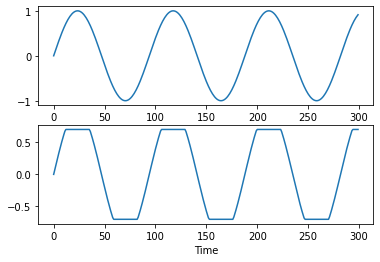

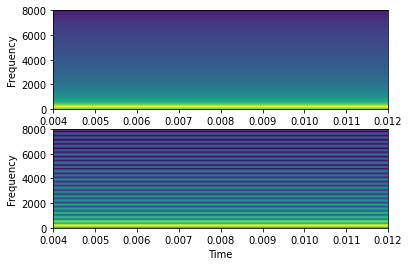

In [9]:
import torch
from speechbrain.processing.speech_augmentation import DoClip

clipper = DoClip(clip_low=0.7, clip_high=0.7)
sinusoid = torch.sin(torch.linspace(0,20, 300))
clipped_signal = clipper(sinusoid.unsqueeze(0))

#  plots
plt.figure(1)
plt.subplot(211)
plt.plot(sinusoid)
plt.xlabel('Time')

plt.subplot(212)
plt.plot(clipped_signal.squeeze())
plt.xlabel('Time')

# freq domain
plt.figure(2)
plt.subplot(211)
plt.specgram(sinusoid,Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(clipped_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')





The amount of clipping is controlled with the parameters **clip_low** and **clip_high**, which set the lower and upper threshold over which the signal is clamped. In the frequency domain, clipping adds harmonics in the higher part of the spectrum. 

## 5. Augmentation Lobe
Normally, these disturbances are applied together and activated with a certain probability. To make this easier, in SpeechBrain we have a class called  `TimeDomainSpecAugment` in `speechbrain.lobes.augment`. 

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


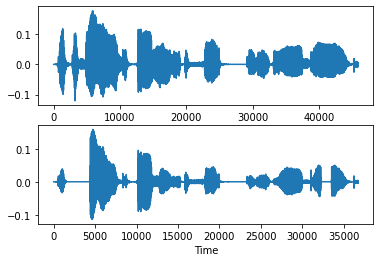

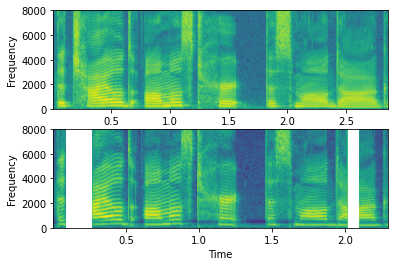

In [10]:
from speechbrain.lobes.augment import TimeDomainSpecAugment

do_augment = TimeDomainSpecAugment(speeds=[80, 110, 120],
                                   perturb_prob=1.0, 
                                   drop_freq_prob=1.0, 
                                   drop_chunk_prob=1.0,
                                   drop_chunk_length_low=1000,
                                   drop_chunk_length_high=3000)

length = torch.ones(1)
augmented_signal = do_augment(clean, length)

#  plots
plt.figure(1)
plt.subplot(211)
plt.plot(clean.squeeze())
plt.xlabel('Time')

plt.subplot(212)
plt.plot(augmented_signal.squeeze())
plt.xlabel('Time')

# freq domain
plt.figure(2)
plt.subplot(211)
plt.specgram(clean.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(212)
plt.specgram(augmented_signal.squeeze(),Fs=16000)
plt.xlabel('Time')
plt.ylabel('Frequency')

Audio(augmented_signal,rate=16000)



In SpeechBrain, we often perform **on-the-fly speech augmentation**. In practice, we augment in a different way all the training batches created at each epoch. This kind of speech augmentation relies on basic signal processing techniques that can be implemented very fast on GPUs. Doing it on-the-fly for every training batch doesn't slow down the training loop significantly.

The current tutorial was based on our time-domain implementation. We also have an implementation of the standard SpecAugment proposed in [1]. See ` SpecAugment` in `speechbrain.lobes.augment`. 

# References
[1] Daniel S. Park, William Chan, Yu Zhang, Chung-Cheng Chiu, Barret Zoph, Ekin D. Cubuk, Quoc V. Le, *SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition*, Proc. Interspeech 2019, [ArXiv](https://arxiv.org/abs/1904.08779)

[2] Mirco Ravanelli, Jianyuan Zhong, Santiago Pascual, Pawel Swietojanski, Joao Monteiro, Jan Trmal, Yoshua Bengio:
*Multi-Task Self-Supervised Learning for Robust Speech Recognition*. Proc. of ICASSP 2020 [ArXiv]()

# **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


# **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```